In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
%matplotlib inline

In [304]:
# read in the training and testing data into Pandas.DataFrame objects
input_df = pd.read_csv('http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv', header=0)
submit_df  = pd.read_csv('http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv',  header=0)

In [305]:
input_df.shape

(891, 12)

In [306]:
# merge the two DataFrames into one
df = pd.concat([input_df, submit_df])

# re-number the combined data set so there aren't duplicate indexes
df.head()
df.reset_index(inplace=True)
df.head()

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [307]:
# reset_index() generates a new column that we don't want, so let's get rid of it
df.drop('index', axis=1, inplace=True)

# the remaining columns need to be reindexed so we can access the first column at '0' instead of '1'
df = df.reindex_axis(input_df.columns, axis=1)

print (df.shape[1], "columns:", df.columns.values)
print ("Row count:", df.shape[0])

12 columns: ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
Row count: 1309


## Dealing with the missing data and categorical data

In [308]:
# Replace missing values with "U0"
df['Cabin'][df.Cabin.isnull()] = 'U0'

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [309]:
# Take the median of all non-null Fares and use that for all missing values
df['Fare'][np.isnan(df['Fare']) ] = df['Fare'].median()

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [310]:
# Replace missing values with most common port
df.Embarked[ df.Embarked.isnull() ] = df.Embarked.dropna().mode().values
# Create a dataframe of dummy variables for each distinct value of 'Embarked'
# Rename the columns from 'S', 'C', 'Q' to 'Embarked_S', 'Embarked_C', 'Embarked_Q'
# Add the new variables back to the original data set
#df = pd.concat([df, pd.get_dummies(df['Embarked']).rename(columns=lambda x: 'Embarked_' + str(x))], axis=1)
df["Embarked_ID"] = pd.factorize(df["Embarked"])[0]

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [311]:
import re

# Replace missing values with "U0"
df['Cabin'][df.Cabin.isnull()] = 'U0'
 
# Create a feature for the deck
df['Deck'] = df['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
df['Deck'] = pd.factorize(df['Deck'])[0]
 
# Create binary features for each deck
#decks = pd.get_dummies(df['Deck']).rename(columns=lambda x: 'Deck_' + str(x))
#df = pd.concat([df, decks], axis=1)

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [312]:
def get_num(x):
    if(re.compile("([0-9]+)").search(x) != None):
        return re.compile("([0-9]+)").search(x).group()
    else:
        return 0      

In [313]:
# Create feature for the room number
df['Room'] = df['Cabin'].map( lambda x : get_num(x)).astype(int) + 1

In [314]:
# Divide all fares into quartiles
df['Fare_bin'] = pd.qcut(df['Fare'], 4)

# qcut() creates a new variable that identifies the quartile range, but we can't use the string so either
# factorize or create dummies from the result
df['Fare_bin_id'] = pd.factorize(df['Fare_bin'])[0]

#df = pd.concat([df, pd.get_dummies(df['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))], axis=1)

In [315]:
# how many different names do they have? 
df['Names'] = df['Name'].map(lambda x: len(re.split(' ', x)))

In [316]:
# What is each person's title? 
df['Title'] = df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

# Group low-occuring, related titles together
df['Title'][df.Title == 'Jonkheer'] = 'Master'
df['Title'][df.Title.isin(['Ms','Mlle'])] = 'Miss'
df['Title'][df.Title == 'Mme'] = 'Mrs'
df['Title'][df.Title.isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Sir'
df['Title'][df.Title.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'
df['Title_ID'] = pd.factorize(df['Title'])[0]
# Build binary features
#df = pd.concat([df, pd.get_dummies(df['Title']).rename(columns=lambda x: 'Title_' + str(x))], axis=1)

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [317]:
df['Sex'][df['Sex'] == 'male'] = 0
df['Sex'][df['Sex'] == 'female'] = 1

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [318]:
from sklearn.ensemble import RandomForestRegressor
 
### Populate missing ages  using RandomForestClassifier
def setMissingAges(df):
    
    # Grab all the features that can be included in a Random Forest Regressor
    age_df = df[['Age','Embarked_ID','Fare', 'Parch', 'SibSp', 'Title_ID','Pclass','Deck']]
    
    # Split into sets with known and unknown Age values
    knownAge = age_df.loc[ (df.Age.notnull()) ]
    unknownAge = age_df.loc[ (df.Age.isnull()) ]
    
    # All age values are stored in a target array
    y = knownAge.values[:, 0]
    
    # All the other values are stored in the feature array
    X = knownAge.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(unknownAge.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [319]:
# StandardScaler will subtract the mean from each value then scale to the unit variance
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
df =setMissingAges(df)
df['Age_scaled'] = scaler.fit_transform(df['Age'])

D:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [320]:
df['Age_bin'] = pd.qcut(df['Age'], 5)
df['Age_bin_id'] = pd.factorize(df['Age_bin'])[0]

In [321]:
df['Fare_scaled'] = scaler.fit_transform(df['Fare'])
df['Pclass_scaled'] = scaler.fit_transform(df['Pclass'])
df['Parch_scaled'] = scaler.fit_transform(df['Parch'])
df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'])
df['Names_scaled'] = scaler.fit_transform(df['Names'])
df['CabinNumber_scaled'] = scaler.fit_transform(df['Room'])
df['Age_bin_id_scaled'] = scaler.fit_transform(df['Age_bin_id'])
df['Fare_bin_id_scaled'] = scaler.fit_transform(df['Fare_bin_id'])
df["Embarked_ID_scaled"] = scaler.fit_transform(df['Embarked_ID'])

D:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\Program Files\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\Program Files\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Program Files\Anaconda2\lib\site-p

In [322]:
def processTicket():
    global df
    
    # extract and massage the ticket prefix
    df['TicketPrefix'] = df['Ticket'].map( lambda x : getTicketPrefix(x.upper()))
    df['TicketPrefix'] = df['TicketPrefix'].map( lambda x: re.sub('[\.?\/?]', '', x) )
    df['TicketPrefix'] = df['TicketPrefix'].map( lambda x: re.sub('STON', 'SOTON', x) )
        
    # create binary features for each prefix
    #prefixes = pd.get_dummies(df['TicketPrefix']).rename(columns=lambda x: 'TicketPrefix_' + str(x))
    #df = pd.concat([df, prefixes], axis=1)
    
    # factorize the prefix to create a numerical categorical variable
    df['TicketPrefixId'] = pd.factorize(df['TicketPrefix'])[0]
    
    # extract the ticket number
    df['TicketNumber'] = df['Ticket'].map( lambda x: getTicketNumber(x) )
    
    # create a feature for the number of digits in the ticket number
    df['TicketNumberDigits'] = df['TicketNumber'].map( lambda x: len(x) ).astype(np.int)
    
    # create a feature for the starting number of the ticket number
    df['TicketNumberStart'] = df['TicketNumber'].map( lambda x: x[0:1] ).astype(np.int)
    
    # The prefix and (probably) number themselves aren't useful
    df.drop(['TicketPrefix', 'TicketNumber'], axis=1, inplace=True)
    

def getTicketPrefix(ticket):
    match = re.compile("([a-zA-Z\.\/]+)").search(ticket)
    if match:
        return match.group()
    else:
        return 'U'

def getTicketNumber(ticket):
    match = re.compile("([\d]+$)").search(ticket)
    if match:
        return match.group()
    else:
        return '0'
    

In [323]:
df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'Embarked_ID', u'Deck', u'Room', u'Fare_bin', u'Fare_bin_id', u'Names',
       u'Title', u'Title_ID', u'Age_scaled', u'Age_bin', u'Age_bin_id',
       u'Fare_scaled', u'Pclass_scaled', u'Parch_scaled', u'SibSp_scaled',
       u'Names_scaled', u'CabinNumber_scaled', u'Age_bin_id_scaled',
       u'Fare_bin_id_scaled', u'Embarked_ID_scaled'],
      dtype='object')

In [324]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_bin_id,Fare_scaled,Pclass_scaled,Parch_scaled,SibSp_scaled,Names_scaled,CabinNumber_scaled,Age_bin_id_scaled,Fare_bin_id_scaled,Embarked_ID_scaled
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,...,0,-0.503291,0.841916,-0.445,0.481288,-0.075501,-0.420654,-1.409996,-1.323333,-0.603436
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,...,1,0.734744,-1.546098,-0.445,0.481288,2.458619,2.843455,-0.712722,-0.434547,0.927373
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,...,0,-0.490240,0.841916,-0.445,-0.479087,-0.920208,-0.420654,-1.409996,0.454238,-0.603436
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,...,1,0.383183,-1.546098,-0.445,0.481288,2.458619,4.302704,-0.712722,-0.434547,-0.603436
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,...,1,-0.487824,0.841916,-0.445,-0.479087,-0.075501,-0.420654,-0.712722,0.454238,-0.603436


##  Automated feature generation (Feature Engineering)

In [325]:
numerics = df.loc[:, ['Age_scaled', 'Fare_scaled', 'Pclass_scaled', 'Parch_scaled', 'SibSp_scaled', 
                      'Names_scaled', 'CabinNumber_scaled', 'Age_bin_id_scaled', 'Fare_bin_id_scaled','Embarked_ID_scaled']]

# for each pair of variables, determine which mathmatical operators to use based on redundancy
for i in range(0, numerics.columns.size-1):
    for j in range(0, numerics.columns.size-1):
        col1 = str(numerics.columns.values[i])
        col2 = str(numerics.columns.values[j])
        # multiply fields together (we allow values to be squared)
        if i <= j:
            name = col1 + "*" + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:,i] * numerics.iloc[:,j], name=name)], axis=1)
        # add fields together
        if i < j:
            name = col1 + "+" + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:,i] + numerics.iloc[:,j], name=name)], axis=1)
        # divide and subtract fields from each other
        if not i == j:
            name = col1 + "/" + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:,i] / numerics.iloc[:,j], name=name)], axis=1)
            name = col1 + "-" + col2
            df = pd.concat([df, pd.Series(numerics.iloc[:,i] - numerics.iloc[:,j], name=name)], axis=1)

In [326]:
print(df.shape)

(1309, 257)


## Use a Spearman correlation to identify and remove highly correlated features

In [327]:
# calculate the correlation matrix (ignore survived and passenger id fields)
df_corr = df.drop(['Survived', 'PassengerId'],axis=1).corr(method='spearman')

# create a mask to ignore self-
mask = np.ones(df_corr.columns.size) - np.eye(df_corr.columns.size)
df_corr = mask * df_corr

drops = []
# loop through each variable
for col in df_corr.columns.values:
    # if we've already determined to drop the current variable, continue
    if np.in1d([col],drops):
        continue
    
    # find all the variables that are highly correlated with the current variable 
    # and add them to the drop list 
    corr = df_corr[abs(df_corr[col]) > 0.98].index
    drops = np.union1d(drops, corr)

print ("\nDropping", drops.shape[0], "highly correlated features...\n", drops)
df.drop(drops, axis=1, inplace=True)


Dropping 48 highly correlated features...
 ['Age_bin_id_scaled' 'Age_bin_id_scaled-Age_scaled'
 'Age_bin_id_scaled-CabinNumber_scaled' 'Age_bin_id_scaled-Fare_scaled'
 'Age_bin_id_scaled-Names_scaled' 'Age_bin_id_scaled-Parch_scaled'
 'Age_bin_id_scaled-Pclass_scaled' 'Age_bin_id_scaled-SibSp_scaled'
 'Age_scaled' 'CabinNumber_scaled' 'CabinNumber_scaled-Age_scaled'
 'CabinNumber_scaled-Fare_scaled' 'CabinNumber_scaled-Names_scaled'
 'CabinNumber_scaled-Parch_scaled' 'CabinNumber_scaled-Pclass_scaled'
 'CabinNumber_scaled-SibSp_scaled' 'Embarked_ID_scaled'
 'Fare_bin_id_scaled' 'Fare_bin_id_scaled-Age_bin_id_scaled'
 'Fare_bin_id_scaled-Age_scaled' 'Fare_bin_id_scaled-CabinNumber_scaled'
 'Fare_bin_id_scaled-Fare_scaled' 'Fare_bin_id_scaled-Names_scaled'
 'Fare_bin_id_scaled-Parch_scaled' 'Fare_bin_id_scaled-Pclass_scaled'
 'Fare_bin_id_scaled-SibSp_scaled' 'Fare_scaled' 'Fare_scaled-Age_scaled'
 'Names_scaled' 'Names_scaled-Age_scaled' 'Names_scaled-Fare_scaled'
 'Names_scaled-Parch_

## Using PCA to reduce dimentionality
It is typically useful for linear models unless Lasso regression model is used. When Random Forest model is used, using PCA isn’t particularly helpful.

In [328]:
# Minimum percentage of variance we want to be described by the resulting transformed components
#from sklearn.decomposition import PCA
#variance_pct = .99

# Create PCA object
#pca = PCA(n_components=variance_pct)

# Transform the initial features
#X_transformed = pca.fit_transform(X,y)

# Create a data frame from the PCA'd data
#pcaDataFrame = pd.DataFrame(X_transformed)

#print pcaDataFrame.shape[1], " components describe ", str(variance_pct)[1:], "% of the variance"

## Random Forest

In [379]:
from sklearn.ensemble import RandomForestClassifier
input_df = df.loc[0:890,:]
input_df.shape

(891, 209)

In [380]:
input_df.drop(["Name","Ticket","Embarked","Cabin","Title","Fare_bin",'Age_bin'], axis=1, inplace=True)

features_list = input_df.columns.values[2::]
X = input_df.values[:, 2::]
y = input_df["Survived"].values

# Fit a random forest with (mostly) default parameters to determine feature importance
forest = RandomForestClassifier(max_leaf_nodes= 16,criterion='gini', max_features = 4,
                                min_samples_split =12,min_samples_leaf=1,oob_score=True, n_estimators=250)
forest = forest.fit(X, y)

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [386]:
feature_importance = forest.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold =31
# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0]

# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
print ("\n", important_features.shape[0], "Important features(>", fi_threshold, "% of max importance):\n",important_features)

# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
print ("\nFeatures sorted by importance (DESC):\n", important_features[sorted_idx])


 4 Important features(> 31 % of max importance):
 ['Sex' 'Title_ID' 'Age_scaled+Pclass_scaled' 'Fare_scaled-Pclass_scaled']

Features sorted by importance (DESC):
 ['Sex' 'Title_ID' 'Age_scaled+Pclass_scaled' 'Fare_scaled-Pclass_scaled']


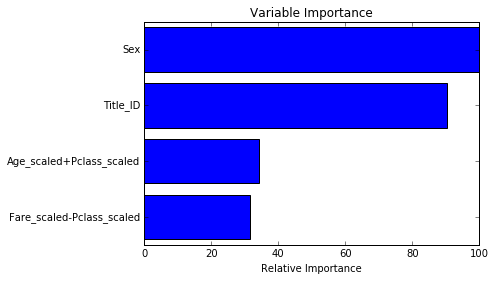

In [387]:
# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()

# Remove non-important features from the feature set, and reorder those remaining
X = X[:, important_idx][:, sorted_idx]

# Grid Search and Randomized Search

In [339]:
# Utility function to report optimal parameters
# (adapted from http://scikit-learn.org/stable/auto_examples/randomized_search.html)
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
import operator

def report(grid_scores, n_top=5):
    params = None
    top_scores = sorted(grid_scores, key=operator.itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Parameters with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
              score.mean_validation_score, np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if params == None:
            params = score.parameters
    
    return params

In [340]:
# The most common value for the max number of features to look at in each split is sqrt(# of features)
sqrtfeat = np.sqrt(X.shape[1]) 
sqrtfeat

1.7320508075688772

In [341]:
X.shape[0]

891L

In [342]:
# Simple grid test (162 combinations)
grid_test1 = { "n_estimators"      : [50,100, 250, 500],
               "criterion"         : ["gini", "entropy"],
               "max_depth"         : [5, 10,20, 25,30],
               "min_samples_split" : [2, 5, 10] }

# Large randomized test using max_depth to control tree size (5000 possible combinations)
random_test1 = { "n_estimators"      : np.rint(np.linspace(X.shape[0]/16, X.shape[0]/2, 5)).astype(int),
                 "criterion"         : ["gini", "entropy"],
                 "max_features"      : np.rint(np.linspace(1, X.shape[1], 5)).astype(int),
                 "max_depth"         : np.rint(np.linspace(1, X.shape[1]*2, 10)).astype(int),
                 "min_samples_split" : np.rint(np.linspace(2, X.shape[0]/50, 10)).astype(int)} 
                

# Large randomized test using min_samples_leaf and max_leaf_nodes to control tree size (50k combinations)
random_test2 = { "n_estimators"      : np.rint(np.linspace(X.shape[0]/16, X.shape[0]/2, 5)).astype(int),
                 "criterion"         : ["gini", "entropy"],
                 "max_features"      : np.rint(np.linspace(1, X.shape[1], 5)).astype(int),
                 "min_samples_split" : np.rint(np.linspace(2, X.shape[0]/50, 10)).astype(int),
                 "min_samples_leaf"  : np.rint(np.linspace(1, X.shape[0]/50, 10)).astype(int), 
                 "max_leaf_nodes"    : np.rint(np.linspace(10, X.shape[0]/50, 10)).astype(int) }

forest = RandomForestClassifier(oob_score=True)

In [343]:
print ("Hyperparameter optimization using GridSearchCV...")
grid_search = GridSearchCV(forest, grid_test1, cv=10)
grid_search.fit(X, y)

Hyperparameter optimization using GridSearchCV...


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 250, 500], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [344]:
best_params_from_grid_search = report(grid_search.grid_scores_)

Parameters with rank: 1
Mean validation score: 0.8103 (std: 0.0365)
Parameters: {'min_samples_split': 10, 'n_estimators': 500, 'criterion': 'entropy', 'max_depth': 25}

Parameters with rank: 2
Mean validation score: 0.8092 (std: 0.0360)
Parameters: {'min_samples_split': 10, 'n_estimators': 500, 'criterion': 'gini', 'max_depth': 20}

Parameters with rank: 3
Mean validation score: 0.8092 (std: 0.0369)
Parameters: {'min_samples_split': 10, 'n_estimators': 500, 'criterion': 'gini', 'max_depth': 30}

Parameters with rank: 4
Mean validation score: 0.8092 (std: 0.0360)
Parameters: {'min_samples_split': 10, 'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 30}

Parameters with rank: 5
Mean validation score: 0.8081 (std: 0.0377)
Parameters: {'min_samples_split': 10, 'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 25}



In [180]:
print "Hyperparameter optimization using RandomizedSearchCV with max_depth parameter..."
grid_search = RandomizedSearchCV(forest, random_test1, cv=10, n_iter=100)
grid_search.fit(X, y)
best_params_from_rand_search1 = report(grid_search.grid_scores_)

Hyperparameter optimization using RandomizedSearchCV with max_depth parameter...
Parameters with rank: 1
Mean validation score: 0.8440 (std: 0.0363)
Parameters: {'n_estimators': 55, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 3}

Parameters with rank: 2
Mean validation score: 0.8418 (std: 0.0401)
Parameters: {'n_estimators': 445, 'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 10, 'max_features': 3}

Parameters with rank: 3
Mean validation score: 0.8406 (std: 0.0408)
Parameters: {'n_estimators': 348, 'min_samples_split': 15, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 1}

Parameters with rank: 4
Mean validation score: 0.8406 (std: 0.0393)
Parameters: {'n_estimators': 348, 'min_samples_split': 2, 'criterion': 'gini', 'max_depth': 10, 'max_features': 2}

Parameters with rank: 5
Mean validation score: 0.8395 (std: 0.0469)
Parameters: {'n_estimators': 55, 'min_samples_split': 12, 'criterion': 'entropy', 'max_depth': 8, 'max_featur

In [196]:
print "...and using RandomizedSearchCV with min_samples_leaf + max_leaf_nodes parameters..."
grid_search = RandomizedSearchCV(forest, random_test2, cv=10, n_iter=500)
grid_search.fit(X, y)
best_params_from_rand_search2 = report(grid_search.grid_scores_)

...and using RandomizedSearchCV with min_samples_leaf + max_leaf_nodes parameters...
Parameters with rank: 1
Mean validation score: 0.8272 (std: 0.0331)
Parameters: {'max_leaf_nodes': 16, 'min_samples_leaf': 1, 'n_estimators': 250, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 12}

Parameters with rank: 2
Mean validation score: 0.8260 (std: 0.0333)
Parameters: {'max_leaf_nodes': 16, 'min_samples_leaf': 1, 'n_estimators': 55, 'max_features': 3, 'criterion': 'entropy', 'min_samples_split': 10}

Parameters with rank: 3
Mean validation score: 0.8260 (std: 0.0272)
Parameters: {'max_leaf_nodes': 12, 'min_samples_leaf': 1, 'n_estimators': 55, 'max_features': 1, 'criterion': 'gini', 'min_samples_split': 7}

Parameters with rank: 4
Mean validation score: 0.8249 (std: 0.0332)
Parameters: {'max_leaf_nodes': 15, 'min_samples_leaf': 3, 'n_estimators': 445, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 5}

Parameters with rank: 5
Mean validation score: 0.8249 (std: 0.02

**Go back to change the parameters in the random forest model**

# Learning Curve

<module 'matplotlib.pyplot' from 'D:\Program Files\Anaconda2\lib\site-packages\matplotlib\pyplot.py'>

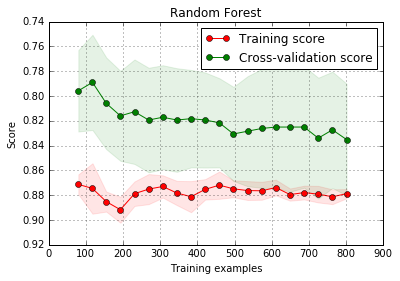

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.gca().invert_yaxis()
    return plt
title = "Random Forest"
plot_learning_curve(forest,title, X, y, cv = 10, train_sizes=np.linspace(.1, 1., 15))

# Test Set Prediction

In [388]:
submit_df = df.loc[891:1309,:]

submit_df.drop(["Name","Ticket","Embarked","Cabin","Title","Fare_bin",'Age_bin'], axis=1, inplace=True)

features_list = submit_df.columns.values[1::]
submit_X = submit_df.values[:, 2::]

D:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [389]:
submit_X = submit_X[:, important_idx][:, sorted_idx]

In [390]:
forest = forest.fit(X, y)
print (forest.score(X, y))

0.875420875421


In [391]:
submit_y = forest.predict(submit_X)

In [393]:
PassengerId = np.array(submit_df["PassengerId"]).astype(int)

my_solution_grid = pd.DataFrame(submit_y, PassengerId, columns = ["Survived"])

# Check that your data frame has 418 entries
print(my_solution_grid.shape)

# Write your solution to a csv file with the name my_solution.csv
my_solution_grid.to_csv("my_ran.csv", index_label = ["PassengerId"])

(418, 1)
